### Initializatoin & definitions

In [10]:
#hide
! [ -e /content ] && pip install -Uqq fastbook duckduckgo_search
import fastbook
fastbook.setup_book()

In [11]:
from fastbook import *
from duckduckgo_search import ddg_images

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [17]:
from fastdownload import download_url

def download(name, url):
    dest = name+'.jpg'
    download_url(url, dest, show_progress=False)
def show(name):
    dest = name + '.jpg'
    im = Image.open(dest)
    return im.to_thumb(256,256)

path = Path('glyphs')

### Data collection

In [14]:
maya_glyphs = search_images('maya glyphs')

Searching for 'maya glyphs'


In [15]:
dest = path/'maya'
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=maya_glyphs)

In [18]:
petroglyphs = search_images('petroglyphs photo')

Searching for 'petroglyphs photo'


In [19]:
dest = path/'petro'
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=petroglyphs)

In [20]:
egypt_glyphs = search_images('egyptian glyphs')

Searching for 'egyptian glyphs'


In [21]:
dest = path/'egypt'
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=egypt_glyphs)

In [22]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#4) [None,None,None,None]

new unseen images

In [23]:
download('petro1', 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Golpayegan.petroglyphs0101.jpg/220px-Golpayegan.petroglyphs0101.jpg')

In [24]:
download('maya-drawing','https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.test.bbc.co.uk%2Fstaticarchive%2Ff5069064298a98a2ff8461118e710bc2c7c40e41.jpg&f=1&nofb=1&ipt=71c8b250985d439a2d19782ec463a44d130f4ce237b045da086781b840a9243b&ipo=images')

In [26]:
download('maya-photo', 'https://www.worldhistory.org/img/r/p/500x600/2307.jpg?v=1659217332')

In [27]:
download('egypt-photo', 'https://media.istockphoto.com/id/98464453/photo/egyptian-hieroglyph.jpg?s=612x612&w=0&k=20&c=CGChMe-xT2UAuQhpIZA1jluQle3sPTcxnGwpqtpRF7c=')

### Training

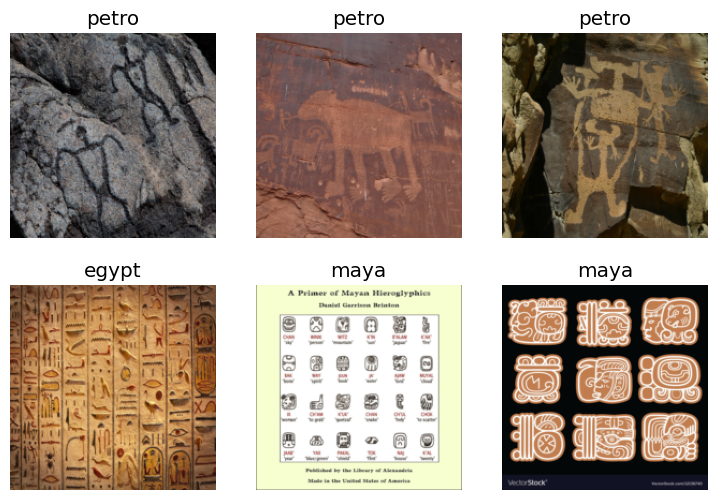

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [29]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [30]:
def classify(test_img):
    is_maya,_,probs = learn.predict(test_img)
    print(test_img)
    print(list(zip(dls.vocab, probs)))

In [34]:
classify('maya-photo.jpg')
classify('maya-drawing.jpg')


maya-photo.jpg
[('egypt', tensor(0.0007)), ('maya', tensor(0.9983)), ('petro', tensor(0.0010))]


maya-drawing.jpg
[('egypt', tensor(0.0277)), ('maya', tensor(0.9523)), ('petro', tensor(0.0200))]


In [35]:
classify('petro1.jpg')
classify('egypt-photo.jpg')

petro1.jpg
[('egypt', tensor(0.0008)), ('maya', tensor(0.0003)), ('petro', tensor(0.9989))]


egypt-photo.jpg
[('egypt', tensor(0.7794)), ('maya', tensor(0.1915)), ('petro', tensor(0.0291))]


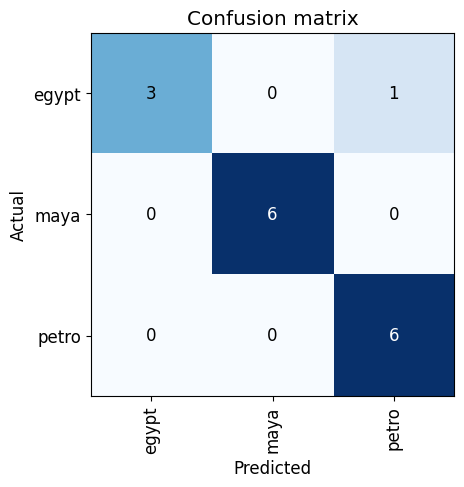

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

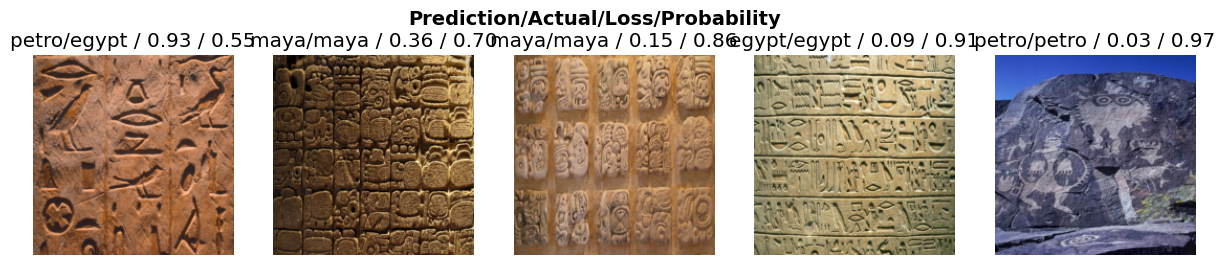

In [37]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [67]:
!ls glyphs/maya | wc -l

27


In [66]:
for idx in cleaner.delete(): 
    print('removing')
    cleaner.fns[idx].unlink()

removing


#### Experimenting with data transformations

In [79]:
ResizeMethod()

fastcore.basics.ResizeMethod(Squish='squish', Crop='crop', Pad='pad')

In [80]:
PadMode()

fastcore.basics.PadMode(Zeros='zeros', Border='border', Reflection='reflection')

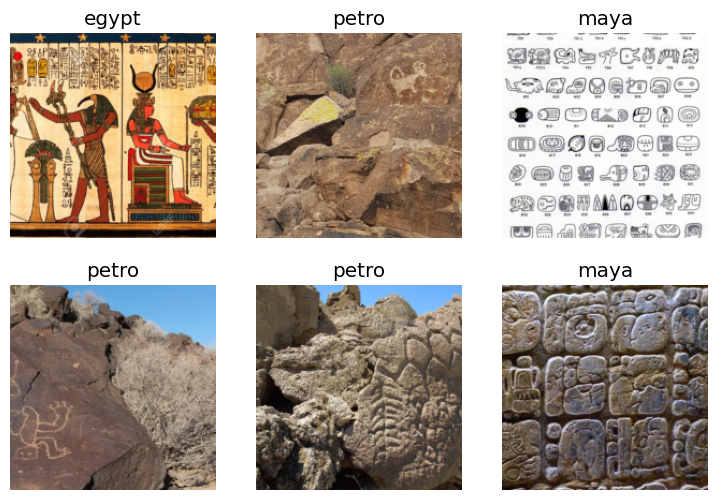

In [39]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
    # item_tfms=[Resize(192, method='pad', pad_mode='zeros')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

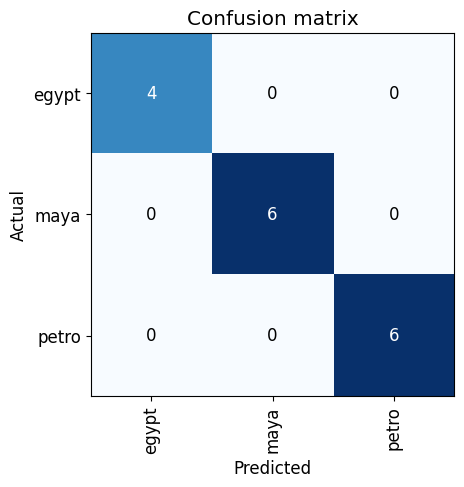

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Export, import and inference

In [42]:
learn.export()

In [16]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [17]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
learn_inf.predict('maya-photo.jpg')

('maya', TensorBase(0), TensorBase([9.9988e-01, 1.1994e-04]))